Imports

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.datasets import CIFAR10
from torch.utils.data.dataset import Dataset
import cv2
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Data Loading and mask generation

In [3]:
# Custom Dataset class that automates that generation of mask and masked image using OpenCV libraries

class LoadData(Dataset):
  def __init__(self, images):
    self.input_img = images
    self.data_len = len(self.input_img)
    self.indexes = np.arange(len(self.input_img))
    self.T=[]
    for img in self.input_img:
      Y=img/255
      X, M= self.generate_data(img)
      self.T.append((X,M,Y))

  def __getitem__(self, index):
    return self.T[index]

  def __len__(self):
    return self.data_len

  def generate_data(self, img): 
    img_copy = img  
    Masked_image, mask = self.generate_mask(img_copy)
    Masked_image= Masked_image/255
    mask = mask/255
    return Masked_image, mask

  def generate_mask(self, img):
    # create a mask with white background
    mask = np.full((32,32,3), 255, np.uint8)
    for i in range(np.random.randint(1,10)):
      x_start = np.random.randint(1, 32)
      y_start = np.random.randint(1, 32)
      x_end =  np.random.randint(1, 32)
      y_end = np.random.randint(1, 32)
      width = np.random.randint(1,3)
      cv2.line(mask,(x_start,y_start),(x_end,y_end),(0,0,0),width)
    masked_image = img
    masked_image[mask==0] = 255
    return masked_image,mask

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_data = CIFAR10(root='data/Train/', train=False, download=True, transform=transforms)

Files already downloaded and verified


In [5]:
# Load test data in batch size of 100

dataset = LoadData(train_data.test_data)
train_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size= 100)

Partial convolution implementation

In [6]:

# Utility initialization function for initializing initial weights and bias in a network
def weights_init():
    def init_fun(m):
      if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.05)

    return init_fun

# Implementation of Partial Convolution class
# We have used two different convolutions for image and the mask
class PartialConv2D(nn.Module):
  def __init__(self, in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 padding,
                 stride: int=1
                 ):
    super(PartialConv2D,self).__init__()
    self.convImg = nn.Conv2d(in_channels=in_channels,out_channels=out_channels, kernel_size= kernel_size, stride=stride, padding=padding, bias=True)
    self.convMask = nn.Conv2d(in_channels=in_channels,out_channels=out_channels, kernel_size= kernel_size, stride=stride, padding=padding, bias=False)
    self.convImg.apply(weights_init())
    torch.nn.init.constant_(self.convMask.weight, 1.0)
    for param in self.convMask.parameters():
      param.requires_grad = False
  def forward(self, image, mask):
    inter_output = self.convImg(image*mask)
    if self.convImg.bias is not None:
      out_bias = self.convImg.bias.view(1, -1, 1, 1).expand_as(
                inter_output)
    else:
      out_bias = torch.zeros_like(inter_output)
    with torch.no_grad():
      output_mask = self.convMask(mask)
    one_where_holes = output_mask == 0
    mask_sum = output_mask.masked_fill_(one_where_holes, 1.0)
    out = (inter_output - out_bias) / mask_sum + out_bias
    out = out.masked_fill_(one_where_holes, 0.0)
    mask = torch.ones_like(out)
    mask = mask.masked_fill_(one_where_holes, 0.0)
    return out, mask

Network Implementation

In [7]:
# Network implemention
# UNet architecture - The network has 8 encoder modules and 8 decoder modules. Each of the modules 
# consist of a partial convolution layer, followed by batch normalization and a LeakyRelu.

class ImageInPaintingNet(nn.Module):
  def __init__(self):
    super(ImageInPaintingNet, self).__init__() 
    pad = ((3-1)//2,(3-1)//2)
    
        # Downsampling
    self.enc_con1 = PartialConv2D(3,32,kernel_size=3,stride=1, padding=pad)
    self.enc_bn1 = nn.BatchNorm2d(num_features= 32)
    self.enc_ac1 = nn.LeakyReLU()

    self.enc_con2 = PartialConv2D(32,32,kernel_size=3,stride=2, padding=1)
    self.enc_bn2 = nn.BatchNorm2d(num_features= 32)
    self.enc_ac2 = nn.LeakyReLU()

    self.enc_con3 = PartialConv2D(32,64,kernel_size=3,stride=1, padding=pad)
    self.enc_bn3 = nn.BatchNorm2d(64)
    self.enc_ac3 = nn.LeakyReLU()

    self.enc_con4 = PartialConv2D(64,64,kernel_size=3,stride=2, padding=1)
    self.enc_bn4 = nn.BatchNorm2d(64)
    self.enc_ac4 = nn.LeakyReLU()

    self.enc_con5 = PartialConv2D(64,128,kernel_size=3,stride=1, padding=pad)
    self.enc_bn5 = nn.BatchNorm2d(128)
    self.enc_ac5 = nn.LeakyReLU()

    self.enc_con6 = PartialConv2D(128,128,kernel_size=3,stride=2, padding=1)
    self.enc_bn6 = nn.BatchNorm2d(128)
    self.enc_ac6 = nn.LeakyReLU()

    self.enc_con7 = PartialConv2D(128,256,kernel_size=3,stride=1, padding=pad)
    self.enc_bn7 = nn.BatchNorm2d(256)
    self.enc_ac7 = nn.LeakyReLU()

    self.enc_con8 = PartialConv2D(256,256,kernel_size=3,stride=2, padding=1)
    self.enc_bn8 = nn.BatchNorm2d(256)
    self.enc_ac8 = nn.LeakyReLU()

    self.dec_con8 = PartialConv2D(256+256, 256, kernel_size=3, padding=pad)
    self.dec_bn8 = nn.BatchNorm2d(256)
    self.dec_ac8 = nn.LeakyReLU()

    self.dec_con7 = PartialConv2D(256, 128, kernel_size=3, padding=pad)
    self.dec_bn7 = nn.BatchNorm2d(128)
    self.dec_ac7 = nn.LeakyReLU()

    self.dec_con6 = PartialConv2D(128+128, 128, kernel_size=3, padding=pad)
    self.dec_bn6 = nn.BatchNorm2d(128)
    self.dec_ac6 = nn.LeakyReLU()

    self.dec_con5 = PartialConv2D(128, 64, kernel_size=3, padding=pad)
    self.dec_bn5 = nn.BatchNorm2d(64)
    self.dec_ac5 = nn.LeakyReLU()

    self.dec_con4 = PartialConv2D(64+64, 64, kernel_size=3, padding=pad)
    self.dec_bn4 = nn.BatchNorm2d(64)
    self.dec_ac4 = nn.LeakyReLU()

    self.dec_con3 = PartialConv2D(64, 32, kernel_size=3, padding=pad)
    self.dec_bn3 = nn.BatchNorm2d(32)
    self.dec_ac3 = nn.LeakyReLU()

    self.dec_con2 = PartialConv2D(32+32, 32, kernel_size=3, padding=pad)
    self.dec_bn2 = nn.BatchNorm2d(32)
    self.dec_ac2 = nn.LeakyReLU()

    self.dec_con1 = PartialConv2D(32, 3, kernel_size=3, padding=pad)
    self.dec_bn1 = nn.BatchNorm2d(3)
    self.dec_ac1 = nn.Sigmoid()


  # Custom implementation of forward to incorporate skip connections in encoder-decoder architecture
  def forward(self, input, input_mask):
    out_enc = {}
    out_mask_enc = {}
    (out_enc['0'], out_mask_enc['0']) = (input, input_mask)
    prev_key = '0'

    for i in range(0, 7, 2):
      for j in range(1, 3):
        next_key = '{:d}'.format(i+j)
        cur_enc_con = 'enc_con{:d}'.format(i+j)
        cur_enc_bn = 'enc_bn{:d}'.format(i+j)
        cur_enc_ac = 'enc_ac{:d}'.format(i+j)
        (x, out_mask_enc[next_key]) = getattr(self, cur_enc_con)(out_enc[prev_key], out_mask_enc[prev_key])
        x = getattr(self, cur_enc_bn)(x)
        out_enc[next_key] = getattr(self, cur_enc_ac)(x)
        prev_key = next_key
    
    out_dec = {}
    out_mask_dec = {}
    prev_out, prev_mask_out = out_enc['8'], out_mask_enc['8']
    prev_out = F.interpolate(prev_out, scale_factor=2, mode='bilinear', align_corners=True)
    prev_mask_out = F.interpolate(prev_mask_out, scale_factor=2, mode='bilinear', align_corners=True)
    dec_inp = torch.cat([out_enc['7'], prev_out], 1)
    dec_mask = torch.cat([out_mask_enc['7'], prev_mask_out], 1)
    (x, out_mask_dec['8']) = self.dec_con8(dec_inp, dec_mask)
    x = self.dec_bn8(x)
    out_dec['8'] = self.dec_ac8(x)
    prev_out, prev_mask_out = out_dec['8'], out_mask_dec['8']

    (x, out_mask_dec['7']) = self.dec_con7(prev_out, prev_mask_out)
    x = self.dec_bn7(x)
    out_dec['7'] = self.dec_ac7(x)
    prev_out, prev_mask_out = out_dec['7'], out_mask_dec['7']

    for i in range(6, 0, -2):
      enc_out, enc_mask_out = out_enc['{:d}'.format(i-1)], out_mask_enc['{:d}'.format(i-1)]
      prev_out = F.interpolate(prev_out, scale_factor=2, mode='bilinear', align_corners=True)
      prev_mask_out = F.interpolate(prev_mask_out, scale_factor=2, mode='bilinear', align_corners=True)
      dec_inp = torch.cat([enc_out, prev_out], 1)
      dec_mask = torch.cat([enc_mask_out, prev_mask_out], 1)

      #layer i
      (x, prev_mask_out) = getattr(self, 'dec_con{:d}'.format(i))(dec_inp, dec_mask)
      x = getattr(self, 'dec_bn{:d}'.format(i))(x)
      prev_out = getattr(self, 'dec_ac{:d}'.format(i))(x)

      #layer i-1
      (x, prev_mask_out) = getattr(self, 'dec_con{:d}'.format(i-1))(prev_out, prev_mask_out)
      x = getattr(self, 'dec_bn{:d}'.format(i-1))(x)
      prev_out = getattr(self, 'dec_ac{:d}'.format(i-1))(x)
      #prev_out = F.interpolate(prev_out, scale_factor=2, mode='bilinear')
      #prev_mask_out = F.interpolate(prev_mask_out, scale_factor=2, mode='bilinear')

    #prev_out = F.interpolate(prev_out, scale_factor=2, mode='bilinear')
    #prev_mask_out = F.interpolate(prev_mask_out, scale_factor=2, mode='bilinear')
    return (prev_out, prev_mask_out)

In [14]:
model = ImageInPaintingNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Model training

In [9]:
def train(maskedImage, inputMask, inputImage, criterion, optimizer, model):
  
  #predImage = model(maskedImage, inputMask)
  (predImage, pred_mask) = model(maskedImage.float().permute(0, 3, 1, 2).to(device), inputMask.float().permute(0, 3, 1, 2).to(device))
  loss_train = criterion(predImage, inputImage.float().permute(0, 3, 1, 2).to(device))
  
  optimizer.zero_grad()
  loss_train.backward()
  optimizer.step()
  return (predImage, loss_train.item())

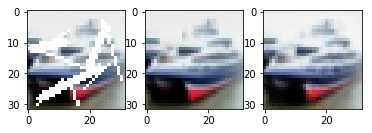

Epoch  0 :  0.0006515970424516126


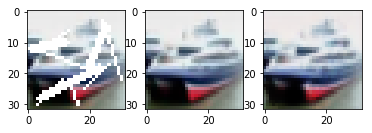

Epoch  1 :  0.0006529006460914388


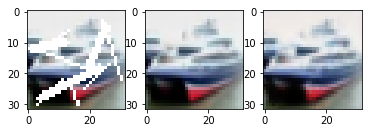

Epoch  2 :  0.0006620314682368189


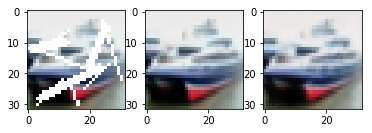

Epoch  3 :  0.0006969180045416579


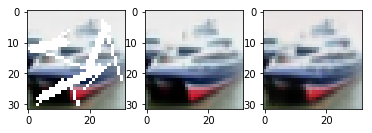

Epoch  4 :  0.0007069047034019604


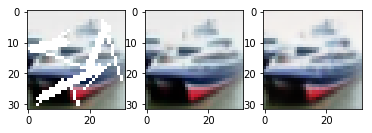

Epoch  5 :  0.0007078481756616384


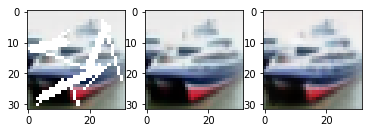

Epoch  6 :  0.0006753600604133681


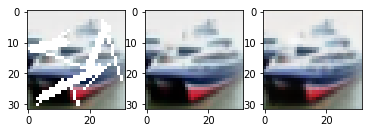

Epoch  7 :  0.0006583851989125833


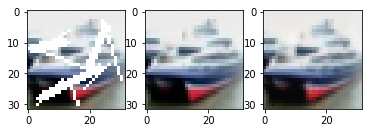

Epoch  8 :  0.0006735636433586478


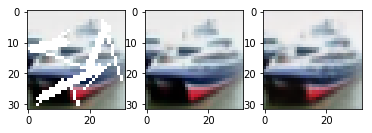

Epoch  9 :  0.0007019771682098508


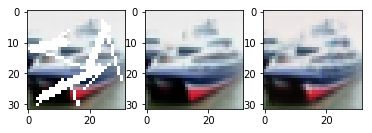

KeyboardInterrupt: 

In [17]:
#loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = 4)
loss_list = []
for epoch in range(200):
  totalLoss = 0
  avgLoss = 0
  batch = 0
  flag = True
  avg_loss = 0.0
  flag = True
  for (maskedImage, mask, image) in train_loader:
    (predImage, loss) = train(maskedImage, mask, image, criterion, optimizer, model)
    predImage = predImage.permute(0, 2, 3, 1)[1]
    avg_loss = avg_loss + loss
    if flag == True:
      plt.subplot(1,3, 1)
      plt.imshow(maskedImage[1])
      plt.subplot(1,3, 2)
      plt.imshow(image[1])
      plt.subplot(1,3, 3)
      plt.imshow(predImage.cpu().detach().numpy())
      plt.show()
      flag = False
  avg_loss = avg_loss/len(train_loader)
  loss_list.append(avg_loss)
  print("Epoch ", epoch, ": ", avg_loss)


[0.007751791477203369, 0.002935678530484438, 0.0023065346654038876, 0.0021037486160639675, 0.001978549505583942, 0.0019007493427488952, 0.0018421884800773115, 0.0017938662995584309, 0.0017488481290638446, 0.0017107782885432243, 0.0016833934187889098, 0.0016530159930698573, 0.001622212438378483, 0.0015968676726333796, 0.0015748421009629966, 0.0015269190492108464, 0.0015035742521286011, 0.001483278152300045, 0.0014766145206522197, 0.0014361091027967632, 0.0013966311060357838, 0.0013669595564715564, 0.0013463166961446404, 0.0013108995335642248, 0.0012898278562352061, 0.0012837524723727256, 0.0012856940913479776, 0.0012607915606349706, 0.0012008854298619553, 0.0011795090523082762, 0.001172462971881032, 0.00115271910734009, 0.0011273091792827472, 0.001125091799767688, 0.001114347740658559, 0.0010905451560392976, 0.0010848442098358646, 0.0010964475804939866, 0.0011110269784694537, 0.0011180993815651163, 0.0010917235648958013, 0.0010701330308802426, 0.0010371413856046273, 0.001012485453393310

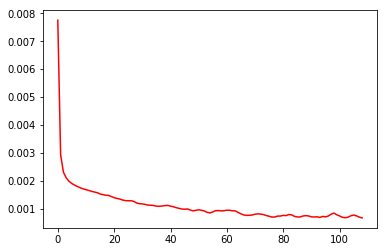

In [16]:
print(loss_list)
plt.plot(np.array(loss_list), 'r')
#torch.save(model.state_dict(), "ImageInpainting.pt")